# Indonesia: The Capital vs The Tourist Attraction

Indonesia is a big and vast countries, ranked 4 in hte list of countries by population. Based on the [worldmeters.info](https://www.worldometers.info/world-population/indonesia-population/), currently Indonesia has a population of 275 millions people. 

![Indonesia](https://images.mapsofworld.com/earthquake/1482303515indonesia-map.gif)

Indonesia is divided into 34 different provinces, scattered in 5 main islands and thousands of small islands. One of the most popular province is the capital province of Jakarta which is also one of the main financial hub in Indonesia. Another popular province is the province of Bali, which is famous as a tourist attraction both for domestic and international tourist with total contribution of almost 29% of the national foreign exchange.

This project will explore and find different cluster of neighborhood both in Jakarta and Bali to see if there is certain characteristics that is associated with each province or if both provinces share the same characteristics based on various places and landmarks on its neighborhood.

# Library

The following is the list of packages required for this project.

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

# Web Scraping
import requests
from requests import get
from bs4 import BeautifulSoup

# Map and Spatial Data
import folium
from geopy.geocoders import Nominatim

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline

# Machine Learning and Dimensionality Reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Data

The postal code and information about each province and city will be gathered from https://postcode.id/, which will give us the following fields from the data table:

- Propinsi (Province): The name of the province
- Jenis (City Type): Type of the city: either city or regency
- Kabupaten/Kota: The name of the city/regency
- Kecamatan: The name of district in the city/regency
- Keluarahan: The name of the neighborhood
- Postcode: The postal code of the neighborhood

I will also use the `geocoder` package to get the latitude and longitude information from each district/neighborhood. To get the list of places and landmarks in each area, I will use the `Foursquare API`.

With the mentioned data collection method, I will be able to extracts various places and landmarks. I will use the clustering analysis to find different characteristics of each city and the respective neighborhood to see if Jakarta and Bali has the same overall characteristics based on each province's main features. Another business perspective is to determine if it is better to open up a restaurant in Bali or in Jakarta. Is Bali as a tourist attraction more associated with restaurant than Jakarta? Is it better to setup a contractor office in Jakarta since Jakarta is a capital and an economic districts? We will find out in this project.

## Jakarta Province

The following code will scrape the data from the https://postcode.id/dki-jakarta/ and will give me the list of information about the district and neighborhood in the capital province of Jakarta. Jakarta is a big province and is divided into 5 cities: Central Jakarta, South Jakarta, East Jakarta, West Jakarta, and North Jakarta.

In [2]:
# URL for the postal code information
url = "https://postcode.id/dki-jakarta/"
response = get(url)
html_soup = BeautifulSoup(response.text, 'html.parser')

In the following code, you will be able to get the table from the website. The table is located at the class of `supsystic-tables-wrap` and can be easily acquired with the `BeautifulSoup`.

In [3]:
table_content = html_soup.find_all('div', class_ = "supsystic-tables-wrap")
table_content = table_content[0].find_all('td')

raw_text = []
for i in np.arange(0, len(table_content)):
 raw_text.append(table_content[i].text)

province = raw_text[::6]
city_type = raw_text[1::6]
city = raw_text[2::6]
district = raw_text[3::6]
neighborhood = raw_text[4::6]
postal_code = raw_text[5::6]

df_jakarta = pd.DataFrame({'province':province, 'city_type':city_type, 'city':city, 'district': district, 'neighborhood':neighborhood, 'postal_code':postal_code})
df_jakarta.head()

,province,city_type,city,district,neighborhood,postal_code
0,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,Pinangsia,11110
1,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,Glodok,11120
2,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,Keagungan,11130
3,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,Krukut,11140
4,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,Taman Sari,11150


Let's check the number of neighborhood in Jakarta.

In [4]:
df_jakarta.shape

(267, 6)

Let's see if there is any duplicated post code from the data.

In [5]:
df_jakarta[ df_jakarta['postal_code'].duplicated() ].shape

(34, 6)

There are 34 neighborhood with the same/duplicated postal code. We will let it be as it is since we want to get more locations for different neighborhood.

## Bali Province

The following code will scrape the data from the https://postcode.id/bali/ and will give me the list of information about the district and neighborhood in the province of Bali.

In [6]:
url = "https://postcode.id/bali/"
response = get(url)
html_soup = BeautifulSoup(response.text, 'html.parser')
table_content = html_soup.find_all('div', class_ = "supsystic-tables-wrap")
table_content = table_content[0].find_all('td')

raw_text = []
for i in np.arange(0, len(table_content)):
 raw_text.append(table_content[i].text)

province = raw_text[::6]
city_type = raw_text[1::6]
city = raw_text[2::6]
district = raw_text[3::6]
neighborhood = raw_text[4::6]
postal_code = raw_text[5::6]

df_bali = pd.DataFrame({'province':province, 'city_type':city_type, 'city':city, 'district': district, 'neighborhood':neighborhood, 'postal_code':postal_code})
df_bali.head()

,province,city_type,city,district,neighborhood,postal_code
0,Bali,Kab.,Badung,Mengwi,Abianbase,80351
1,Bali,Kab.,Badung,Mengwi,Baha,80351
2,Bali,Kab.,Badung,Mengwi,Buduk,80351
3,Bali,Kab.,Badung,Mengwi,Cemagi,80351
4,Bali,Kab.,Badung,Mengwi,Gulingan,80351


Let's check the number of neighborhood in Bali.

In [7]:
df_bali.shape

(714, 6)

Let's check if there is any duplicated postal code in the data as well.

In [8]:
df_bali[ df_bali['postal_code'].duplicated()].shape

(610, 6)

There are about 600 neighborhood with the same/duplicated postal code. Turns out even the number of neighborhood is significantly bigger than Jakarta, most of the neighborhood in Bali shares the same postal code.

## Get Latitude and Longitude from Neighborhood

In this part, we will get the geographic information from each neighborhood by using the `geopy` package to acquire the latitude and longitude. This will help us visualize the data using interactive map. If the geocoder failed to find any address or the latitude and the longitude, we will return `NaN`. Since the data collection process is quite long, I have saved the data previously in a .csv file.

In [9]:
geolocator = Nominatim(user_agent="my_user_agent")

city = 'Jakarta'
country = 'Indonesia'
loc_lat = []
loc_lng = []

# Run this code if you want to use the geolocator
#for neighborhood in df_jakarta.neighborhood:
#    print(neighborhood)
#    loc = geolocator.geocode(neighborhood+',' + city +',' + country)
#   if str(type(loc)) == "<class 'NoneType'>": # If the geolocator failed to find this address
#        loc_lat.append(np.NaN)
#        loc_lng.append(np.NaN)
#    else:
#        loc_lat.append(loc.latitude)
#        loc_lng.append(loc.longitude)

#df_jakarta['Latitude'] = loc_lat
#df_jakarta['Longitude'] = loc_lng
#df_jakarta.dropna(inplace=True)

In [10]:
df_jakarta = pd.read_csv("data/Jakarta_geo.csv")
df_jakarta

,province,city_type,city,district,neighborhood,postal_code,Latitude,Longitude
0,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,Pinangsia,11110,-6.135969,106.814264
1,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,Glodok,11120,-6.144709,106.813092
2,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,Keagungan,11130,-6.150733,106.814550
3,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,Krukut,11140,-6.157010,106.814747
4,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,Taman Sari,11150,-6.154194,106.824489
...,...,...,...,...,...,...,...,...
255,DKI Jakarta,Kab.,Kepulauan Seribu,Kepulauan Seribu Selatan,Pulau Pari,14520,-5.943927,106.630932
256,DKI Jakarta,Kab.,Kepulauan Seribu,Kepulauan Seribu Selatan,Pulau Tidung,14520,-5.803887,106.525306
257,DKI Jakarta,Kab.,Kepulauan Seribu,Kepulauan Seribu Utara,Pulau Panggang,14530,-5.734967,106.601201
258,DKI Jakarta,Kab.,Kepulauan Seribu,Kepulauan Seribu Utara,Pulau Harapan,14540,-5.652208,106.576511


Let's visualize the data by making a map using the `folium` package.

In [11]:
# create map of Manhattan using latitude and longitude values
latitude = -6.20000
longitude = 106.81666
map_jakarta = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_jakarta['Latitude'], df_jakarta['Longitude'], df_jakarta['neighborhood'] + ',' + df_jakarta['district'] + ',' + df_jakarta['city']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_jakarta)  
    
map_jakarta

We will do the same process as well for the province of Bali. I also saved the data in a .csv file on the next code cell.

In [12]:
city = 'Bali'
country = 'Indonesia'
loc_lat = []
loc_lng = []

#for neighborhood in df_bali.neighborhood:
#    print(neighborhood)
#    loc = geolocator.geocode(neighborhood+',' + city +',' + country)
#    if str(type(loc)) == "<class 'NoneType'>": 
#        loc_lat.append(np.NaN)
#        loc_lng.append(np.NaN)
#    else:
#        loc_lat.append(loc.latitude)
#        loc_lng.append(loc.longitude)

#df_bali['Latitude'] = loc_lat
#df_bali['Longitude'] = loc_lng
#df_bali.dropna(inplace=True)


In [13]:
df_bali = pd.read_csv("data/Bali_geo.csv")
df_bali

,province,city_type,city,district,neighborhood,postal_code,Latitude,Longitude
0,Bali,Kab.,Badung,Mengwi,Abianbase,80351,-8.592831,115.170929
1,Bali,Kab.,Badung,Mengwi,Baha,80351,-8.524183,115.187557
2,Bali,Kab.,Badung,Mengwi,Buduk,80351,-8.606281,115.157630
3,Bali,Kab.,Badung,Mengwi,Cemagi,80351,-8.631570,115.111241
4,Bali,Kab.,Badung,Mengwi,Gulingan,80351,-8.544971,115.181794
...,...,...,...,...,...,...,...,...
666,Bali,Kab.,Tabanan,Baturiti,Luwus,82191,-8.391901,115.187558
667,Bali,Kab.,Tabanan,Baturiti,Mekarsari,82191,-8.360482,115.183388
668,Bali,Kab.,Tabanan,Baturiti,Perean,82191,-8.314270,115.337741
669,Bali,Kab.,Tabanan,Baturiti,Perean Kangin,82191,-8.421580,115.206987


Let's visualize the data as well for the province of Bali.

In [14]:
# create map of Manhattan using latitude and longitude values
latitude = -8.409518
longitude = 115.188919
map_bali = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_bali['Latitude'], df_bali['Longitude'], df_bali['neighborhood'] + ',' + df_bali['district'] + ',' + df_bali['city']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bali)  
    
map_bali

## Foursquare API

Using the Foursquare API, we will be able to retrieve certain number of nearby venues on each neighborhood. You can sign up for the Foursquare API on this link: https://foursquare.com/developers/apps

In [15]:
CLIENT_ID = '*****' # your Foursquare ID
CLIENT_SECRET = '*****' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

The following code will help you get 100 nearby venues within 500 m of the neighborhood coordinates.

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v["venue"]['name'], 
            v["venue"]['location']['lat'], 
            v["venue"]['location']['lng'],  
            v["venue"]['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
# Run this code if you want to retrieve the venues
# jakarta_venues = getNearbyVenues(df_jakarta.neighborhood, df_jakarta.Latitude, df_jakarta.Longitude)
# jakarta_venues.to_csv("data/jakarta_venue.csv", index = False)

# Load pre-runned API
jakarta_venues = pd.read_csv("data/jakarta_venue.csv")
jakarta_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Pinangsia,-6.135969,106.814264,Museum Bank Indonesia,-6.137120,106.813148,History Museum
1,Pinangsia,-6.135969,106.814264,Starbucks,-6.137456,106.814468,Coffee Shop
2,Pinangsia,-6.135969,106.814264,Wonderloft Hostel,-6.136670,106.812576,Hostel
3,Pinangsia,-6.135969,106.814264,Colosseum Club,-6.132878,106.813873,Nightclub
4,Pinangsia,-6.135969,106.814264,Kota Tua,-6.135388,106.812949,Historic Site
...,...,...,...,...,...,...,...
3846,Pulau Panggang,-5.734967,106.601201,"Private Beach Karya Island ,Karya Island Kepul...",-5.734361,106.603256,Nudist Beach
3847,Pulau Panggang,-5.734967,106.601201,Dermaga Pulau Panggang,-5.737411,106.600566,Harbor / Marina
3848,Pulau Harapan,-5.652208,106.576511,Pulau Harapan,-5.652037,106.578137,Beach
3849,Pulau Harapan,-5.652208,106.576511,Pulau Harapan - Dermaga,-5.650094,106.578291,Boat or Ferry


Let's check the top 15 Neighborhood with the highest number of venues.

Text(0.5, 1.0, 'Top 15 Neighborhood Based on Number of Venues')

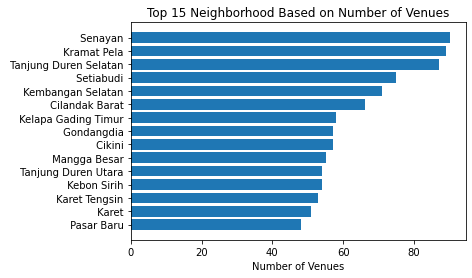

In [19]:
df_agg = jakarta_venues[['Neighborhood', 'Venue']].groupby(['Neighborhood']).count().sort_values(by = 'Venue', ascending = False)[0:15]
df_agg.reset_index(inplace =True)
df_agg = df_agg.sort_values(by = 'Venue')

plt.barh(df_agg.Neighborhood, df_agg.Venue)
plt.xlabel('Number of Venues')
plt.title('Top 15 Neighborhood Based on Number of Venues')

What is the most common Venue category in Jakarta?

Text(0.5, 1.0, 'Top 15 Venue Category Based on Number of Venues')

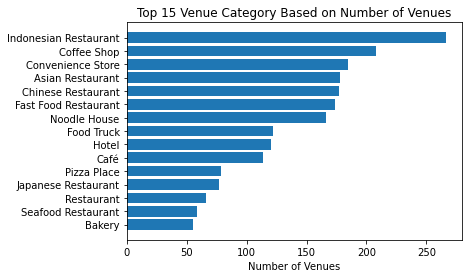

In [20]:
df_agg = jakarta_venues[['Venue Category', 'Venue']].groupby(['Venue Category']).count().sort_values(by = 'Venue', ascending = False)[0:15]
df_agg.reset_index(inplace =True)
df_agg = df_agg.sort_values(by = 'Venue')

plt.barh(df_agg['Venue Category'], df_agg.Venue)
plt.xlabel('Number of Venues')
plt.title('Top 15 Venue Category Based on Number of Venues')

Most venues is related with food and beverage business, with `Indonesian Restaurant`, `Coffee Shop`, and `Convenience Store` as the dominant venues.

Next, we will inspect venues in Bali.

In [21]:
# Run this code if you want to get venue with API
# bali_venues = getNearbyVenues(df_bali.neighborhood, df_bali.Latitude, df_bali.Longitude)
# bali_venues.to_csv("data/bali_venues.csv", index = False)

# Read pre-runed API result
bali_venues = pd.read_csv("data/bali_venues.csv")
bali_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abianbase,-8.592831,115.170929,Sanggar Catur Marga,-8.591650,115.173940,Gym / Fitness Center
1,Kapal,-8.573056,115.184434,Pasar Desa Adat Kapal - Wr.Babi Guling Ibu Nia,-8.572735,115.180101,BBQ Joint
2,Kekeran,-8.268402,114.971329,Jaya Negara Resto,-8.264725,114.970627,Restaurant
3,Kekeran,-8.268402,114.971329,riceview point kekeran,-8.268581,114.967240,Intersection
4,Kuwum,-8.455122,115.187278,Desa Kuwum,-8.451474,115.189093,Rest Area
...,...,...,...,...,...,...,...
1659,Candikuning,-8.273330,115.161244,CLV Hotel & Villa,-8.271241,115.162223,Hotel
1660,Candikuning,-8.273330,115.161244,De Danau Lake View Restaurant,-8.275375,115.163884,Indonesian Restaurant
1661,Candikuning,-8.273330,115.161244,Rumah Makan As Siddiq,-8.275648,115.164122,Indonesian Restaurant
1662,Candikuning,-8.273330,115.161244,Enjung Beji Resort,-8.273521,115.165352,Resort


Text(0.5, 1.0, 'Top 15 Neighborhood Based on Number of Venues')

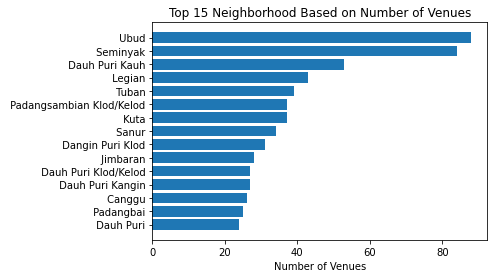

In [22]:
df_agg = bali_venues[['Neighborhood', 'Venue']].groupby(['Neighborhood']).count().sort_values(by = 'Venue', ascending = False)[0:15]
df_agg.reset_index(inplace =True)
df_agg = df_agg.sort_values(by = 'Venue')

plt.barh(df_agg.Neighborhood, df_agg.Venue)
plt.xlabel('Number of Venues')
plt.title('Top 15 Neighborhood Based on Number of Venues')

Text(0.5, 1.0, 'Top 15 Venue Category Based on Number of Venues')

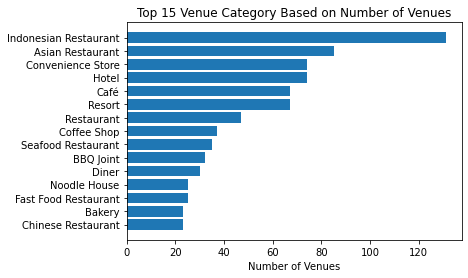

In [23]:
df_agg = bali_venues[['Venue Category', 'Venue']].groupby(['Venue Category']).count().sort_values(by = 'Venue', ascending = False)[0:15]
df_agg.reset_index(inplace =True)
df_agg = df_agg.sort_values(by = 'Venue')

plt.barh(df_agg['Venue Category'], df_agg.Venue)
plt.xlabel('Number of Venues')
plt.title('Top 15 Venue Category Based on Number of Venues')

The top venues in Bali is also consists of `Indonesian Restaurant` and `Convenience Store`, with the `Coffee Shop` replaced by `Asian Restaurant`. Based on the top venue categories, Jakarta and Bali is not so different.

# Cluster Analysis

## Data Preprocessing

In the following code, we will join the postal code and geographic data with the data of each captured venues.

In [24]:
df_geo = df_jakarta.append(df_bali)
df_venue = jakarta_venues.append(bali_venues)
df_final = df_venue.join(df_geo.set_index(['neighborhood', 'Latitude', 'Longitude']), on = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude'])
df_final = df_final[ df_final.duplicated() == False]
df_final.dropna(inplace = True)
df_final

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,province,city_type,city,district,postal_code
0,Pinangsia,-6.135969,106.814264,Museum Bank Indonesia,-6.137120,106.813148,History Museum,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,11110.0
1,Pinangsia,-6.135969,106.814264,Starbucks,-6.137456,106.814468,Coffee Shop,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,11110.0
2,Pinangsia,-6.135969,106.814264,Wonderloft Hostel,-6.136670,106.812576,Hostel,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,11110.0
3,Pinangsia,-6.135969,106.814264,Colosseum Club,-6.132878,106.813873,Nightclub,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,11110.0
4,Pinangsia,-6.135969,106.814264,Kota Tua,-6.135388,106.812949,Historic Site,DKI Jakarta,Kota,Jakarta Barat,Taman Sari,11110.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1649,Payangan,-8.425267,115.245521,badut billiard,-8.421333,115.245461,Pool Hall,Bali,Kab.,Tabanan,Marga,82181.0
1650,Selanbawak,-8.489271,115.178305,Taman Sari Luwak Coffee,-8.488849,115.181890,Café,Bali,Kab.,Tabanan,Marga,82181.0
1651,Selanbawak,-8.489271,115.178305,Bali Agro Product,-8.489094,115.182394,Farm,Bali,Kab.,Tabanan,Marga,82181.0
1652,Angseri,-8.356167,115.155046,Wisata Alam Air Panas Angseri,-8.355240,115.156805,Hot Spring,Bali,Kab.,Tabanan,Baturiti,82191.0


Before we do cluster analysis, make sure that a neighborhood have enough venues, so we will remove neighborhood that only has less than 3 venues.

In [25]:
df_agg = df_final[['Neighborhood', 'Venue']].groupby(['Neighborhood']).count().reset_index().sort_values('Venue')
df_agg = df_agg[ df_agg['Venue'] >= 3]
df_agg

,Neighborhood,Venue
211,Kusamba,3
294,Penatahan,3
373,Sengkidu,3
191,Kendran,3
365,Semarapura Kaja,3
...,...,...
378,Setiabudi,75
412,Tanjung Duren Selatan,87
436,Ubud,88
205,Kramat Pela,89


In [26]:
df_final = df_final.set_index(['Neighborhood']).loc[ df_agg['Neighborhood']].reset_index()
df_final

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,province,city_type,city,district,postal_code
0,Kusamba,-8.559452,115.446111,Komune beach club,-8.561025,115.445072,Hotel Bar,Bali,Kab.,Klungkung,Dawan,80761.0
1,Kusamba,-8.559452,115.446111,KFC,-8.559673,115.449846,American Restaurant,Bali,Kab.,Klungkung,Dawan,80761.0
2,Kusamba,-8.559452,115.446111,Br Anyar Kusamba,-8.559689,115.449926,Historic Site,Bali,Kab.,Klungkung,Dawan,80761.0
3,Penatahan,-8.436031,115.125858,Penatahan natural hot spring,-8.434724,115.125933,Pool,Bali,Kab.,Tabanan,Penebel,82152.0
4,Penatahan,-8.436031,115.125858,Sate Dul (anaknya Ola),-8.434753,115.126579,Mexican Restaurant,Bali,Kab.,Tabanan,Penebel,82152.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4714,Senayan,-6.226911,106.809920,The Atjeh Connection,-6.230938,106.810452,Coffee Shop,DKI Jakarta,Kota,Jakarta Selatan,Kebayoran Baru,12190.0
4715,Senayan,-6.226911,106.809920,Starbucks,-6.225305,106.805788,Coffee Shop,DKI Jakarta,Kota,Jakarta Selatan,Kebayoran Baru,12190.0
4716,Senayan,-6.226911,106.809920,Pipiltin Cocoa,-6.230908,106.808489,Dessert Shop,DKI Jakarta,Kota,Jakarta Selatan,Kebayoran Baru,12190.0
4717,Senayan,-6.226911,106.809920,Han Sol Korean Restaurant,-6.227441,106.812848,Korean Restaurant,DKI Jakarta,Kota,Jakarta Selatan,Kebayoran Baru,12190.0


Next, we will use encoding to transform the `Venue Category` into dummy variables, with value of 1 indicates that the neighborhood had that Venue while 0 indicates that the neighborhood doesn't have those venues. Next, we get the ratio/proportion of each venus for each neighborhood. By doing this, we will acquire the following Neighborhood-Venue matrix.

In [27]:
# one hot encoding
df_onehot = pd.get_dummies(df_final[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Neighborhood'] = df_final['Neighborhood'] 
df_onehot['city'] = df_final['city']

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_grouped = df_onehot.groupby(['Neighborhood', 'city']).mean()
df_grouped.head()

,,ATM,Accessories Store,Acehnese Restaurant,African Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Balinese Restaurant,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Betawinese Restaurant,Big Box Store,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Line,Bus Station,Butcher,Cafeteria,Café,Camera Store,Campground,Cantonese Restaurant,Car Wash,Casino,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Cafeteria,College Communications Building,College Stadium,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Dive Shop,Dive Spot,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,High School,Hindu Temple,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Meatball Place,Indonesian Restaurant,Internet Cafe,Intersection,Island,Italian Restaurant,Japanese Restaurant,Javanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Light Rail Station,Lounge,Malay Restaurant,Manadonese Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Mosque,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Nudist Beach,Office,Optical Shop,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Padangnese Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Shrine,Skate Park,Skating Rink,Ski Area,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Food Gathering,Student Center,Sundanese Restaurant,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tourist Information Cen

In [28]:
# Check the shape of the matrix
df_grouped.shape

(326, 303)

## Clustering with K-Means

We will use the matrix to label the neighborhood using the K-Means clustering method. First, we will determine the number of clusters using the Elbow method.

Text(0.5, 1.0, 'Finding Optimal Number of Clusters with Elbow Method')

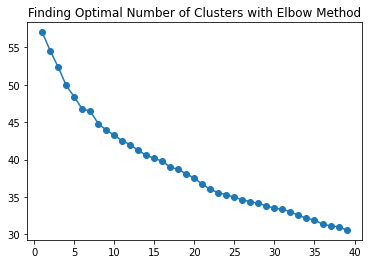

In [29]:

# set max number of clusters
max_cluster = 40

# run k-means clustering
wss = []
for i in np.arange(1, max_cluster):
    kmeans = KMeans(n_clusters= i, random_state=0).fit(df_grouped)
    wss.append(kmeans.inertia_)

plt.plot(np.arange(1, max_cluster), wss)
plt.scatter(np.arange(1, max_cluster), wss)
plt.title("Finding Optimal Number of Clusters with Elbow Method")

Based on the measure of within sum of square from various number of clusters, we can see that the error started to has less significant decrease after 5 clusters. Based on this finding, we will use the k = 5 as the number of clusters.

## Centroid

Using k = 5, we will extract the top 5 Centroid of each clusters to profile the neighborhood inside each cluster.

In [30]:
# Clustering with k = 5
kmeans = KMeans(n_clusters= 5, random_state=0).fit(df_grouped)
df_clust = pd.DataFrame(data = np.round(kmeans.cluster_centers_, decimals= 5 ))
df_clust.columns = df_grouped.columns

# Get the number of neighborhood in each cluster
clust_lab, clust_count = np.unique(kmeans.labels_, return_counts = True)

Based on the top 15 venue categories from each clusters, we can do some simple profiling:

### Cluster 0: Residence Area (36 Neighborhoods)

This cluster has the highest proportion of Convenience Store and Asian Store and has no Mexican or Middle East Restaurant and apparently no detected mobile phone shop, ATM or Men's Store. The cluster is dominated by neighborhood from Jakarta. Since we see less fancy venues in this cluster and more about daily needs convenience store and generic restaurant, we will call them as the residence area.


In [31]:
# Return top 15 venue categories
def plot_cluster(cluster):
    print("Cluster {}: {} Neighborhood".format(cluster, clust_count[cluster]))
    df_print = df_clust.loc[cluster].sort_values(ascending = False)[0:15]
    df_print = pd.DataFrame({'x':df_print}).reset_index().sort_values('x')
    
    return(plt.barh(df_print['index'], df_print.x))

Cluster 0: 37 Neighborhood


<BarContainer object of 15 artists>

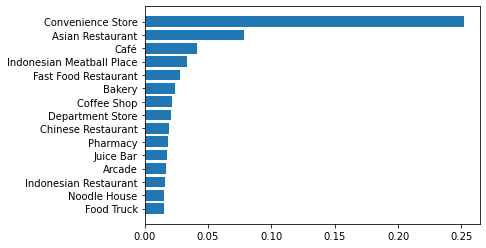

In [32]:
plot_cluster(0)

In [33]:
# Print number of neighborhood in each city
df_labeled = df_grouped.copy()
df_labeled['cluster'] = kmeans.labels_
df_labeled[ df_labeled['cluster'] == 0].reset_index()[['Neighborhood', 'city']].groupby('city').count().sort_values('Neighborhood', ascending = False)

,Neighborhood
city,
Jakarta Timur,10
Jakarta Selatan,7
Denpasar,4
Badung,3
Jakarta Pusat,3
Buleleng,2
Gianyar,2
Jakarta Barat,2
Jakarta Utara,2


### Cluster 1: Food and Beverage (188 Neighborhoods)

This cluster is dominated by neighborhoods from Jakarta, which has a lot of public space for hanging out such as the fast food restaurant, noodle house, Cafe, and coffee shop.


Cluster 1: 188 Neighborhood


<BarContainer object of 15 artists>

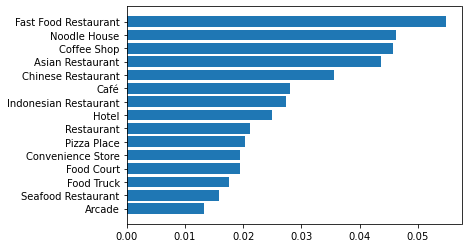

In [34]:
plot_cluster(1)

In [35]:
df_labeled[ df_labeled['cluster'] == 1].reset_index()[['Neighborhood', 'city']].groupby('city').count().sort_values('Neighborhood', ascending = False)

,Neighborhood
city,
Jakarta Selatan,43
Jakarta Barat,34
Jakarta Pusat,25
Jakarta Timur,18
Jakarta Utara,15
Denpasar,11
Buleleng,9
Klungkung,8
Gianyar,7


### Cluster 2: Food Truck and Shopping (22 Neighborhoods)

This cluster has very high amount of food truck venues, followed by the presence of department store, and arcade. This cluster is also the mix of Jakarta and Bali neighborhood, with the highest number of neighborhood is located in the Jakarta Timur (East Jakarta). 

Cluster 2: 22 Neighborhood


<BarContainer object of 15 artists>

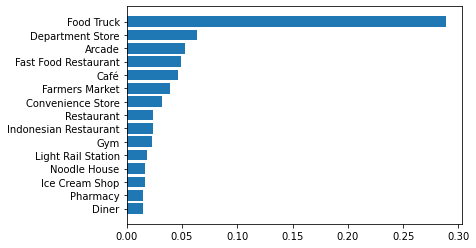

In [36]:
plot_cluster(2)

In [37]:
df_labeled[ df_labeled['cluster'] == 2].reset_index()[['Neighborhood', 'city']].groupby('city').count().sort_values('Neighborhood', ascending = False)

,Neighborhood
city,
Jakarta Timur,8
Jakarta Selatan,3
Denpasar,2
Gianyar,2
Jakarta Utara,2
Karangasem,2
Jakarta Barat,1
Jakarta Pusat,1
Jembrana,1


## Cluster 3: Bali Resort (5 Neighborhoods)

This cluster consists of neighborhood that only has resort and BBQ Joint venues and exclusively only has neighborhood from Bali and no Jakarta. We will call this cluster the Bali resort.

Cluster 3: 5 Neighborhood


<BarContainer object of 15 artists>

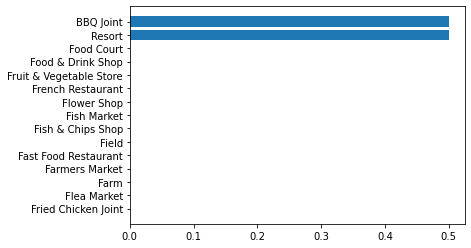

In [38]:
plot_cluster(3)

In [39]:
df_labeled[ df_labeled['cluster'] == 3].reset_index()[['Neighborhood', 'city']].groupby('city').count().sort_values('Neighborhood', ascending = False)

,Neighborhood
city,
Badung,1
Bangli,1
Buleleng,1
Karangasem,1
Klungkung,1


## Cluster 4: Local Food (74 Neighborhoods)

This cluster is also dominated neighborhood from Jakarta with the `Indonesian Restaurant` has the highest presence in this area. If you want to open a local food restaurant, this is a great area.

Cluster 4: 74 Neighborhood


<BarContainer object of 15 artists>

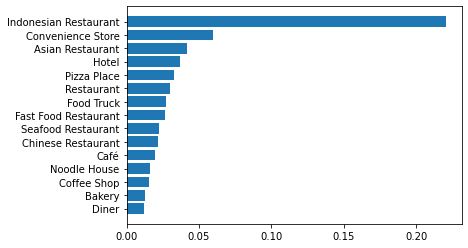

In [40]:
plot_cluster(4)

In [41]:
df_labeled[ df_labeled['cluster'] == 4].reset_index()[['Neighborhood', 'city']].groupby('city').count().sort_values('Neighborhood', ascending = False)

,Neighborhood
city,
Jakarta Timur,15
Jakarta Pusat,14
Jakarta Barat,8
Badung,7
Denpasar,6
Jakarta Selatan,6
Jakarta Utara,5
Gianyar,4
Buleleng,2


## Principal Component Analysis

Using the Principal Component Analysis (PCA), we will look further at which neighborhood is considered as an outlier or has some exceptional qualities compared to others by visualizing the high dimensional data into 2D plot. First, we will check how many information can we get from the first 10 PCs.

Text(0.5, 1.0, 'Cumulative Percentages of Variance Explained')

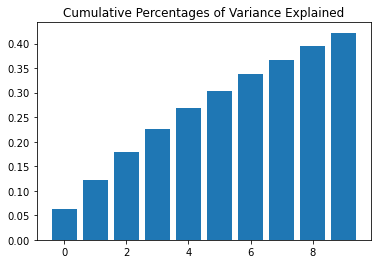

In [42]:
pca_venue = PCA(n_components=10).fit(df_grouped)

plt.bar(np.arange(0, 10), pca_venue.explained_variance_ratio_.cumsum())
plt.title("Cumulative Percentages of Variance Explained")

The first 2 PCs will only give us about 13% of information, so perhaps for better result we could use more PCs to visualize the data. However, we will proceed with 2 PCs for now.

In [43]:
# Transform data with PCA
pca_venue = PCA(n_components=2).fit_transform(df_grouped)

# Create Data.Frame from PCA
pca_df = pd.DataFrame(data = pca_venue, columns = ['principal component 1', 'principal component 2'])
pca_df['Neighborhood'] = df_grouped.reset_index().loc[::1, 'Neighborhood']
pca_df['city'] = df_grouped.reset_index().loc[::1, 'city']
pca_df['cluster'] = kmeans.labels_
pca_df

,principal component 1,principal component 2,Neighborhood,city,cluster
0,-0.084763,-0.032258,Ancol,Jakarta Utara,1
1,0.057824,-0.037516,Angke,Jakarta Barat,4
2,-0.137444,-0.004944,Antiga,Karangasem,2
3,-0.062728,-0.064868,Balekambang,Jakarta Timur,1
4,0.062633,0.096505,Bali Mester,Jakarta Timur,0
...,...,...,...,...,...
321,0.451056,-0.027148,Utan Kayu Selatan,Jakarta Timur,4
322,0.103097,0.012962,Utan Kayu Utara,Jakarta Timur,4
323,-0.138541,-0.076882,Utan Panjang,Jakarta Pusat,1
324,-0.090830,0.003428,Warakas,Jakarta Utara,2


Let's visualize the data into 2D individual plot. We will color the data using the cluster from K-means.

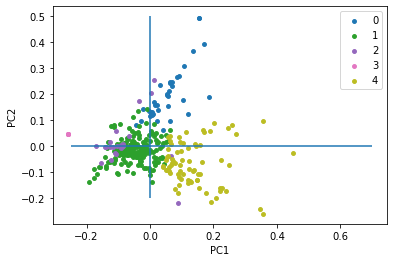

In [44]:
z = np.arange(0, 5)
hot = plt.get_cmap('tab10')
cNorm  = colors.Normalize(vmin=0, vmax= 5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

#plt.scatter(data=pca_df, x  = 'principal component 1', y = 'principal component 2', c='cluster')
# Plot each species
for i in z:
    indx = pca_df['cluster'] == i
    plt.scatter(pca_df['principal component 1'][indx], pca_df['principal component 2'][indx], s=15, color=scalarMap.to_rgba(i), label= i)

plt.hlines(xmin=-0.25, xmax=0.7, y = 0)
plt.vlines(ymax=0.5, ymin= -0.2, x = 0)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper right')

We can see that some data is anomalies or far from the majority of the data. For example, some neighborhood has high number of PC 1 and some has low and high PC2 as well. We will explore further on this neighborhood. You can also see that cluster 1 and cluster 2 mostly located close to the center (0,0) compared to other cluster such as the cluster 0 (residence area that has high convenience store), cluster 4 (Local Food and dominated by Indonesian restaurant) and the cluster 3 (Bali Resort) which means that cluster 1 and cluster 2 is the most common or generic neighborhood area.

First, we will check the neighborhood with PC1 > 0.2 and see the majority of the venue category.

In [45]:
pc1_neigh = pca_df[ pca_df['principal component 1'] > 0.2 ]
pc1_big = pc1_neigh['Neighborhood'].values
df_final[ df_final['Neighborhood'].isin(pc1_big)][['Venue', 'Venue Category']].groupby('Venue Category').count().sort_values('Venue', ascending = False).head()

,Venue
Venue Category,
Indonesian Restaurant,24
Convenience Store,8
Restaurant,4
Asian Restaurant,3
Motorcycle Shop,2


Neighborhood in this group, as suggested by the cluster, is mostly consists from the cluster 4 (Local Food) and thus consists of neighborhood that has high number of Indonesian Restaurant.

Next, we will check the neighborhood with PC1 < -0.2 and see the majority of the venue category.

In [46]:
pc1_neigh = pca_df[ pca_df['principal component 1'] < -0.2 ]
pc1_big = pc1_neigh['Neighborhood'].values
df_final[ df_final['Neighborhood'].isin(pc1_big)][['Venue', 'Venue Category']].groupby('Venue Category').count().sort_values('Venue', ascending = False).head()

,Venue
Venue Category,
BBQ Joint,5
Resort,5


This group consists of our cluster 3, which is the neighborhood of the resort from Bali.

Next, we will check the neighborhood with PC2 > 0.2 and see the majority of the venue category.

In [47]:
pc2_neigh = pca_df[ pca_df['principal component 2'] > 0.2 ]
pc2_big = pc2_neigh['Neighborhood'].values

df_final[ df_final['Neighborhood'].isin(pc2_big)][['Venue', 'Venue Category']].groupby('Venue Category').count().sort_values('Venue', ascending = False).head()

,Venue
Venue Category,
Convenience Store,30
Asian Restaurant,8
Food Truck,6
Café,5
Clothing Store,3


This group is dominated by data from cluster 0, which is also has high number of Convenience Store.

# Conclusion

I will highlight some finding based on our data analysis:

- Jakarta and Bali is not so different, both has high number of food and beverage venues
- Bali has exclusive resort neighborhood area which is has no significant presence in Jakarta
- Jakarta as a capital and the most populous city in Indonesia has a lot of FnB venues as a place for people to hang out
- If you want to open up a restaurant, espescially Indonesian restaurant, you can set up in neighborhood from cluster 4
- If you are a contractor, you can setup your office in Bali in the neighborhood from cluster 3